# **Part 1: Fitting VGG16, MobileNetV2, and ResNet18 to the CFAR-10 Dataset**

* CS486: Robust Machine Learning 
* Drexel University - Spring 2023 
* Luke Ingram

In [1]:
import os
import pickle
import copy

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import DataLoader
import torchvision.transforms as vt
from torchvision import datasets
from torchsummary import summary

from sklearn.model_selection import train_test_split
import numpy as np
from tqdm import tqdm 
import matplotlib.pyplot as plt

from pytorch_cifar.models import VGG, MobileNetV2, ResNet18

We will use three popular image classification models as our test subjects: [VGG16](https://arxiv.org/abs/1409.1556), [MobileNetV2](https://arxiv.org/abs/1801.04381), and [ResNet18](https://arxiv.org/abs/1512.03385). 

Note: These architectures have been slightly modified to support images of shape (3, 32, 32). See this [repo](https://github.com/kuangliu/pytorch-cifar) for specifics.

## **Preparing Data**

In [2]:
# Hyperparams
NUM_CLASSES=10
BATCH_SIZE = 128
EPOCHS = 200 
DEVICE = torch.device('cuda')
SAVES_PATH = os.path.join('models', 'checkpoints', 'classifiers')

### Preparing Data

In [3]:
# Define training & testing transforms

mean, std = [-0.0541, -0.0127,  0.0265], [0.9868, 1.0000, 1.0029]

transform_train = vt.Compose([
    vt.RandomCrop(32, padding=4),
    vt.RandomHorizontalFlip(),
    vt.ToTensor(),
    vt.Normalize(mean, std)
])

# Normalize the test set same as training set without augmentation
transform_test = vt.Compose([
    vt.ToTensor(),
    vt.Normalize(mean, std)
])

# Fetch & Create train, validation, and testing datasets

train_data = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)

train_idx, val_idx = train_test_split(np.arange(len(train_data)), test_size=0.2)

train_sampler = SubsetRandomSampler(train_idx)
val_sampler = SubsetRandomSampler(val_idx)

train_loader = DataLoader(
    train_data, 
    batch_size=BATCH_SIZE,
    num_workers=4,
    sampler= train_sampler
)

val_loader = DataLoader(
    train_data, 
    batch_size=BATCH_SIZE, 
    num_workers=4, 
    sampler=val_sampler
)

test_data = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
def get_mean_and_std(dataset):
    '''Compute the mean and std value of dataset.'''
    dataloader = DataLoader(dataset, batch_size=1, shuffle=True, num_workers=2)
    mean = torch.zeros(3)
    std = torch.zeros(3)
    print('==> Computing mean and std..')
    for inputs, _ in dataloader:
        for i in range(3):
            mean[i] += inputs[:,i,:,:].mean()
            std[i] += inputs[:,i,:,:].std()
    mean.div_(len(dataset))
    std.div_(len(dataset))
    return mean, std

#get_mean_and_std(train_data)

In [5]:
# Validate Sizes
print(f'Training Dataset Size: {len(train_sampler)}')
print(f'Validation Dataset Size: {len(val_sampler)}')
print(f'Testing Dataset Size: {len(test_data)}')

Training Dataset Size: 40000
Validation Dataset Size: 10000
Testing Dataset Size: 10000


In [6]:
# Fetch Class labels from metadata 

labelType = b'label_names'

meta_file = os.path.join("data", "cifar-10-batches-py", "batches.meta")

with open(meta_file, 'rb') as f:
    meta_data = pickle.load(f, encoding='bytes')
    # Extract label names
    label_names = [label.decode('utf-8') for label in meta_data[labelType]]
    f.close()

print(*label_names[:11], '...', sep=', ')

airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck, ...


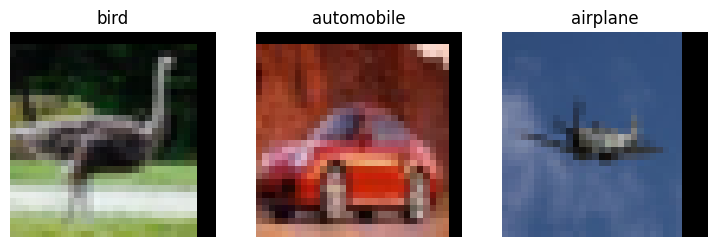

In [7]:
# Preview samples from dataset
def imshow(imgs, labels):
    num_images = 3
    fig, axes = plt.subplots(1, num_images, figsize=(num_images * 3, 3))
    
    for i in range(num_images):
        ax = axes[i]
        img = imgs[i]
        for j in range(3): # unnormalize
            img[j] = img[j] * std[j] + mean[j] 
        npimg = img.numpy()
        ax.imshow(np.transpose(npimg, (1, 2, 0)))
        ax.set_title(train_data.classes[labels[i]])
        ax.axis('off')
    
    plt.show()

dataiter = iter(train_loader)
images, labels = next(dataiter)

# Display each image with its corresponding label
imshow(images[:3], labels[:3])

## **Training, Evaluation, and Plotting Routines**

In [8]:
def train_model(model: nn.Module, device: torch.device, save_name: str, learning_rate: float): 

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=5e-4)
    scaler = torch.cuda.amp.GradScaler()
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

    train_loss = []
    train_acc = []
    val_loss = []
    val_acc = []

    best_acc = 0.0 

    for epoch in range(EPOCHS): 

        sample_cnt = 0
        epoch_loss = 0.0
        correct_cnt = 0

        with tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS} : training Loss 0") as pbar:
            
            model.train()
            
            for _, (inputs, labels) in enumerate(train_loader):

                inputs, labels = inputs.to(device), labels.to(device)

                optimizer.zero_grad()
                with torch.autocast(device.type):
                    outs = model(inputs)
                    loss = criterion(outs, labels)

                    _, preds = torch.max(outs, 1)

                    optimizer.step()

                    epoch_loss += loss.item()
                    correct_cnt += torch.sum(preds == labels.data)
                    sample_cnt += inputs.size(0)
                
                scaler.scale(loss).backward()

                pbar.update(1)
                pbar.set_description(f"Epoch {epoch+1}/{EPOCHS} : training Loss {round(epoch_loss/sample_cnt, 6)}")
        
        epoch_loss /= sample_cnt
        epoch_acc = correct_cnt.double().cpu() / sample_cnt

        train_loss.append(epoch_loss)
        train_acc.append(epoch_acc)

        epoch_val_loss, epoch_val_acc = evaluate(model, criterion, device, val_loader, epoch)
        val_loss.append(epoch_val_loss)
        val_acc.append(epoch_val_acc)

        scheduler.step()

        # Checkpointing (Deepcopy)
        if epoch_val_acc > best_acc:
            print("saving best model val_acc : {:.4f}".format(epoch_val_acc))
            best_acc = epoch_val_acc
            
            model_copy = copy.deepcopy(model)
            model_copy = model_copy.cpu()
            
            model_state_dict = model_copy.state_dict()
            torch.save(model_state_dict, os.path.join(SAVES_PATH, save_name+'.pth'))

            del model_copy
    
    return [train_loss, train_acc, val_loss, val_acc]

            


def evaluate(model: nn.Module, criterion: nn.Module, device: torch.device, loader: DataLoader, epoch: int): 

    model.eval() 

    val_loss = 0.0
    correct_cnt = 0
    sample_cnt = 0

    with tqdm(loader,desc=f'Epoch {epoch+1}/{EPOCHS} : val Loss 0') as pbar:

        for _, (inputs, labels) in enumerate(loader): 

            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            _, preds = torch.max(outputs, 1)
            
            val_loss += loss.item()
            correct_cnt += torch.sum(preds == labels.data)
            sample_cnt += inputs.size(0)

            pbar.update(1) 
            pbar.set_description(f'Epoch {epoch+1}/{EPOCHS} : val Loss {round(val_loss/sample_cnt, 6)}')
        
        val_loss /= sample_cnt
        val_acc = correct_cnt.double().cpu() / sample_cnt

    return val_loss, val_acc

            

def training_summary(train_loss, train_acc, val_loss, val_acc): 
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    # Plot training and validation losses
    ax1.plot(train_loss, label='Training Loss')
    ax1.plot(val_loss, label='Validation Loss')
    ax1.set_title('Training and Validation Loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.legend()

    # Plot training and validation accuracies
    ax2.plot(train_acc, label='Training Accuracy')
    ax2.plot(val_acc, label='Validation Accuracy')
    ax2.set_title('Training and Validation Accuracy')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy')
    ax2.legend()

    # Show the plots
    plt.show()
    

## **VGG16**

In [ ]:
# Initialize VGG16 & Train
vgg16 = VGG('VGG16', num_classes=NUM_CLASSES)

vgg16 = vgg16.to(DEVICE)

summary(vgg16, (3, 32, 32))

train_data = train_model(vgg16, DEVICE, 'vgg16', learning_rate=0.1)

training_summary(*train_data)


## **MobileNetV2**

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             864
       BatchNorm2d-2           [-1, 32, 32, 32]              64
            Conv2d-3           [-1, 32, 32, 32]           1,024
       BatchNorm2d-4           [-1, 32, 32, 32]              64
            Conv2d-5           [-1, 32, 32, 32]             288
       BatchNorm2d-6           [-1, 32, 32, 32]              64
            Conv2d-7           [-1, 16, 32, 32]             512
       BatchNorm2d-8           [-1, 16, 32, 32]              32
            Conv2d-9           [-1, 16, 32, 32]             512
      BatchNorm2d-10           [-1, 16, 32, 32]              32
            Block-11           [-1, 16, 32, 32]               0
           Conv2d-12           [-1, 96, 32, 32]           1,536
      BatchNorm2d-13           [-1, 96, 32, 32]             192
           Conv2d-14           [-1, 96,

Epoch 1/200 : val Loss 0.011542: 100%|██████████| 79/79 [00:10<00:00,  7.65it/s]


saving best model val_acc : 0.4607


Epoch 2/200 : training Loss 0:   0%|          | 0/313 [00:00<?, ?it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x000001ED6DD37F40>
Traceback (most recent call last):
  File "e:\GitHub\DefenseGAN-Pytorch\venv\lib\site-packages\torch\utils\data\dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "e:\GitHub\DefenseGAN-Pytorch\venv\lib\site-packages\torch\utils\data\dataloader.py", line 1436, in _shutdown_workers
    if self._persistent_workers or self._workers_status[worker_id]:
AttributeError: '_MultiProcessingDataLoaderIter' object has no attribute '_workers_status'
Epoch 2/200 : val Loss 0.010383: 100%|██████████| 79/79 [00:10<00:00,  7.55it/s]


saving best model val_acc : 0.5258


Epoch 3/200 : val Loss 0.008034: 100%|██████████| 79/79 [00:10<00:00,  7.37it/s]


saving best model val_acc : 0.6250


Epoch 4/200 : val Loss 0.007468: 100%|██████████| 79/79 [00:10<00:00,  7.49it/s]


saving best model val_acc : 0.6588


Epoch 5/200 : val Loss 0.007242: 100%|██████████| 79/79 [00:10<00:00,  7.30it/s]


saving best model val_acc : 0.6679


Epoch 6/200 : val Loss 0.006948: 100%|██████████| 79/79 [00:11<00:00,  7.11it/s]


saving best model val_acc : 0.6864


Epoch 7/200 : val Loss 0.006469: 100%|██████████| 79/79 [00:11<00:00,  7.10it/s]


saving best model val_acc : 0.7121


Epoch 10/200 : val Loss 0.006075: 100%|██████████| 79/79 [00:10<00:00,  7.40it/s]


saving best model val_acc : 0.7326


Epoch 11/200 : val Loss 0.005857: 100%|██████████| 79/79 [00:10<00:00,  7.45it/s]


saving best model val_acc : 0.7461


Epoch 13/200 : val Loss 0.005521: 100%|██████████| 79/79 [00:10<00:00,  7.66it/s]


saving best model val_acc : 0.7601


Epoch 17/200 : val Loss 0.00498: 100%|██████████| 79/79 [00:10<00:00,  7.41it/s] 


saving best model val_acc : 0.7808


Epoch 36/200 : val Loss 0.00472: 100%|██████████| 79/79 [00:10<00:00,  7.60it/s] 


saving best model val_acc : 0.7921


Epoch 50/200 : val Loss 0.00481: 100%|██████████| 79/79 [00:10<00:00,  7.87it/s] 


saving best model val_acc : 0.7965


Epoch 58/200 : val Loss 0.004707: 100%|██████████| 79/79 [00:09<00:00,  7.92it/s]


saving best model val_acc : 0.7979


Epoch 78/200 : val Loss 0.004349: 100%|██████████| 79/79 [00:09<00:00,  7.95it/s]


saving best model val_acc : 0.8081


Epoch 83/200 : val Loss 0.004077: 100%|██████████| 79/79 [00:10<00:00,  7.90it/s]


saving best model val_acc : 0.8194


Epoch 88/200 : val Loss 0.004043: 100%|██████████| 79/79 [00:09<00:00,  7.96it/s]


saving best model val_acc : 0.8238


Epoch 114/200 : val Loss 0.003773: 100%|██████████| 79/79 [00:10<00:00,  7.49it/s]


saving best model val_acc : 0.8378


Epoch 120/200 : val Loss 0.003458: 100%|██████████| 79/79 [00:10<00:00,  7.50it/s]


saving best model val_acc : 0.8533


Epoch 121/200 : val Loss 0.003399: 100%|██████████| 79/79 [00:10<00:00,  7.46it/s]


saving best model val_acc : 0.8547


Epoch 134/200 : val Loss 0.003352: 100%|██████████| 79/79 [00:10<00:00,  7.88it/s]


saving best model val_acc : 0.8608


Epoch 135/200 : val Loss 0.003306: 100%|██████████| 79/79 [00:09<00:00,  7.94it/s]


saving best model val_acc : 0.8632


Epoch 136/200 : val Loss 0.003101: 100%|██████████| 79/79 [00:10<00:00,  7.86it/s]


saving best model val_acc : 0.8673


Epoch 137/200 : val Loss 0.002837: 100%|██████████| 79/79 [00:09<00:00,  8.01it/s]


saving best model val_acc : 0.8776


Epoch 149/200 : val Loss 0.002817: 100%|██████████| 79/79 [00:10<00:00,  7.79it/s]


saving best model val_acc : 0.8828


Epoch 151/200 : val Loss 0.002791: 100%|██████████| 79/79 [00:09<00:00,  7.95it/s]


saving best model val_acc : 0.8833


Epoch 155/200 : val Loss 0.002711: 100%|██████████| 79/79 [00:10<00:00,  7.88it/s]


saving best model val_acc : 0.8859


Epoch 156/200 : val Loss 0.002616: 100%|██████████| 79/79 [00:09<00:00,  7.90it/s]


saving best model val_acc : 0.8897


Epoch 159/200 : val Loss 0.002519: 100%|██████████| 79/79 [00:10<00:00,  7.88it/s]


saving best model val_acc : 0.8936


Epoch 163/200 : val Loss 0.002554: 100%|██████████| 79/79 [00:09<00:00,  7.92it/s]


saving best model val_acc : 0.8944


Epoch 165/200 : val Loss 0.002581: 100%|██████████| 79/79 [00:10<00:00,  7.82it/s]


saving best model val_acc : 0.8951


Epoch 166/200 : val Loss 0.002575: 100%|██████████| 79/79 [00:09<00:00,  7.94it/s]


saving best model val_acc : 0.8958


Epoch 169/200 : val Loss 0.002253: 100%|██████████| 79/79 [00:10<00:00,  7.88it/s]


saving best model val_acc : 0.9077


Epoch 177/200 : val Loss 0.002249: 100%|██████████| 79/79 [00:10<00:00,  7.82it/s]


saving best model val_acc : 0.9099


Epoch 180/200 : val Loss 0.002307: 100%|██████████| 79/79 [00:10<00:00,  7.85it/s]


saving best model val_acc : 0.9111


Epoch 182/200 : val Loss 0.002284: 100%|██████████| 79/79 [00:09<00:00,  7.91it/s]


saving best model val_acc : 0.9112


Epoch 184/200 : val Loss 0.002256: 100%|██████████| 79/79 [00:10<00:00,  7.81it/s]


saving best model val_acc : 0.9137


Epoch 185/200 : val Loss 0.002287: 100%|██████████| 79/79 [00:10<00:00,  7.83it/s]


saving best model val_acc : 0.9159


Epoch 187/200 : val Loss 0.002306: 100%|██████████| 79/79 [00:09<00:00,  7.92it/s]


saving best model val_acc : 0.9161


Epoch 189/200 : val Loss 0.002233: 100%|██████████| 79/79 [00:09<00:00,  7.94it/s]


saving best model val_acc : 0.9176


Epoch 196/200 : val Loss 0.002255: 100%|██████████| 79/79 [00:10<00:00,  7.89it/s]


saving best model val_acc : 0.9181


Epoch 200/200 : val Loss 0.002286: 100%|██████████| 79/79 [00:10<00:00,  7.87it/s]


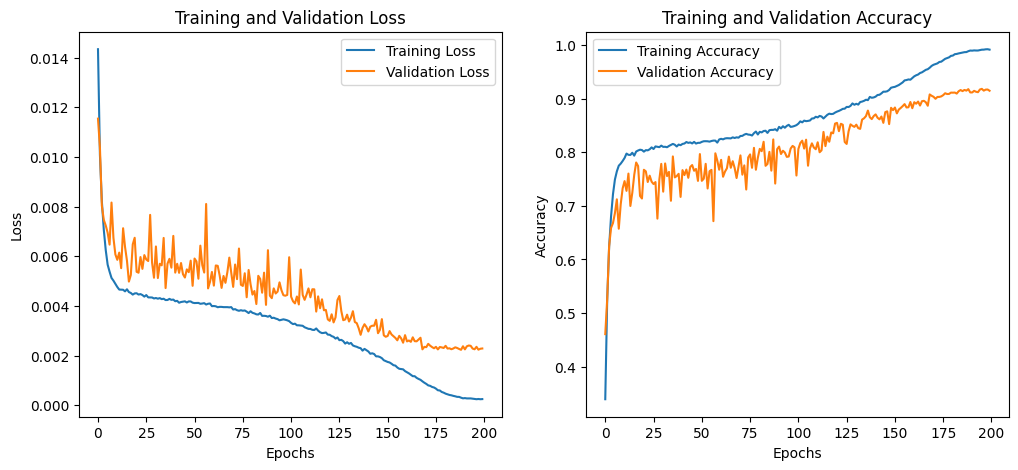

In [ ]:
# Initialize MobileNetV2 & Train
mobilenet = MobileNetV2(num_classes=NUM_CLASSES)

mobilenet = mobilenet.to(DEVICE)

summary(mobilenet, (3, 32, 32))

train_data = train_model(mobilenet, DEVICE, 'mobilenetv2', learning_rate=0.1)

training_summary(*train_data)


## **ResNet18**

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,728
      BatchNorm2d-14          [-1, 128,

Epoch 1/200 : training Loss 0:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 1/200 : val Loss 0.014424: 100%|██████████| 79/79 [00:09<00:00,  8.06it/s]


saving best model val_acc : 0.3456


Epoch 2/200 : val Loss 0.014121: 100%|██████████| 79/79 [00:09<00:00,  8.02it/s]


saving best model val_acc : 0.3708


Epoch 3/200 : val Loss 0.01296: 100%|██████████| 79/79 [00:09<00:00,  8.04it/s] 


saving best model val_acc : 0.4548


Epoch 4/200 : val Loss 0.011364: 100%|██████████| 79/79 [00:09<00:00,  8.01it/s]


saving best model val_acc : 0.4981


Epoch 5/200 : val Loss 0.010312: 100%|██████████| 79/79 [00:09<00:00,  8.00it/s]


saving best model val_acc : 0.5425


Epoch 6/200 : val Loss 0.009263: 100%|██████████| 79/79 [00:09<00:00,  8.01it/s]


saving best model val_acc : 0.5802


Epoch 7/200 : val Loss 0.006556: 100%|██████████| 79/79 [00:09<00:00,  8.00it/s]


saving best model val_acc : 0.7095


Epoch 9/200 : val Loss 0.006044: 100%|██████████| 79/79 [00:09<00:00,  8.03it/s]


saving best model val_acc : 0.7341


Epoch 14/200 : val Loss 0.005131: 100%|██████████| 79/79 [00:09<00:00,  8.02it/s]


saving best model val_acc : 0.7722


Epoch 15/200 : val Loss 0.004729: 100%|██████████| 79/79 [00:09<00:00,  8.02it/s]


saving best model val_acc : 0.8001


Epoch 16/200 : val Loss 0.004647: 100%|██████████| 79/79 [00:09<00:00,  8.03it/s]


saving best model val_acc : 0.8051


Epoch 20/200 : val Loss 0.004374: 100%|██████████| 79/79 [00:10<00:00,  7.86it/s]


saving best model val_acc : 0.8111


Epoch 23/200 : val Loss 0.004381: 100%|██████████| 79/79 [00:09<00:00,  8.02it/s]


saving best model val_acc : 0.8180


Epoch 27/200 : val Loss 0.003923: 100%|██████████| 79/79 [00:09<00:00,  8.02it/s]


saving best model val_acc : 0.8327


Epoch 42/200 : val Loss 0.003654: 100%|██████████| 79/79 [00:09<00:00,  8.02it/s]


saving best model val_acc : 0.8462


Epoch 53/200 : val Loss 0.003452: 100%|██████████| 79/79 [00:09<00:00,  8.02it/s]


saving best model val_acc : 0.8524


Epoch 55/200 : val Loss 0.003351: 100%|██████████| 79/79 [00:09<00:00,  8.01it/s]


saving best model val_acc : 0.8553


Epoch 63/200 : val Loss 0.003311: 100%|██████████| 79/79 [00:09<00:00,  8.00it/s]


saving best model val_acc : 0.8563


Epoch 71/200 : val Loss 0.003233: 100%|██████████| 79/79 [00:09<00:00,  8.00it/s]


saving best model val_acc : 0.8601


Epoch 77/200 : val Loss 0.002994: 100%|██████████| 79/79 [00:09<00:00,  8.02it/s]


saving best model val_acc : 0.8719


Epoch 94/200 : val Loss 0.003161: 100%|██████████| 79/79 [00:09<00:00,  8.01it/s]


saving best model val_acc : 0.8727


Epoch 104/200 : val Loss 0.003082: 100%|██████████| 79/79 [00:09<00:00,  8.01it/s]


saving best model val_acc : 0.8737


Epoch 105/200 : val Loss 0.002747: 100%|██████████| 79/79 [00:09<00:00,  8.01it/s]


saving best model val_acc : 0.8846


Epoch 110/200 : val Loss 0.002803: 100%|██████████| 79/79 [00:09<00:00,  8.01it/s]


saving best model val_acc : 0.8856


Epoch 111/200 : val Loss 0.002827: 100%|██████████| 79/79 [00:09<00:00,  8.00it/s]


saving best model val_acc : 0.8890


Epoch 115/200 : val Loss 0.002702: 100%|██████████| 79/79 [00:09<00:00,  8.01it/s]


saving best model val_acc : 0.8954


Epoch 126/200 : val Loss 0.002698: 100%|██████████| 79/79 [00:09<00:00,  8.02it/s]


saving best model val_acc : 0.8972


Epoch 128/200 : val Loss 0.002672: 100%|██████████| 79/79 [00:10<00:00,  7.88it/s]


saving best model val_acc : 0.8986


Epoch 131/200 : val Loss 0.002569: 100%|██████████| 79/79 [00:09<00:00,  8.01it/s]


saving best model val_acc : 0.9004


Epoch 135/200 : val Loss 0.00259: 100%|██████████| 79/79 [00:09<00:00,  8.02it/s] 


saving best model val_acc : 0.9035


Epoch 140/200 : val Loss 0.002576: 100%|██████████| 79/79 [00:09<00:00,  8.01it/s]


saving best model val_acc : 0.9037


Epoch 141/200 : val Loss 0.002664: 100%|██████████| 79/79 [00:09<00:00,  8.04it/s]


saving best model val_acc : 0.9041


Epoch 144/200 : val Loss 0.002477: 100%|██████████| 79/79 [00:09<00:00,  8.03it/s]


saving best model val_acc : 0.9099


Epoch 146/200 : val Loss 0.002432: 100%|██████████| 79/79 [00:09<00:00,  8.01it/s]


saving best model val_acc : 0.9119


Epoch 150/200 : val Loss 0.002553: 100%|██████████| 79/79 [00:10<00:00,  7.85it/s]


saving best model val_acc : 0.9122


Epoch 151/200 : val Loss 0.002217: 100%|██████████| 79/79 [00:09<00:00,  8.02it/s]


saving best model val_acc : 0.9190


Epoch 156/200 : val Loss 0.002411: 100%|██████████| 79/79 [00:09<00:00,  8.01it/s]


saving best model val_acc : 0.9198


Epoch 157/200 : val Loss 0.002283: 100%|██████████| 79/79 [00:09<00:00,  8.00it/s]


saving best model val_acc : 0.9239


Epoch 158/200 : val Loss 0.002056: 100%|██████████| 79/79 [00:09<00:00,  8.01it/s]


saving best model val_acc : 0.9287


Epoch 162/200 : val Loss 0.002183: 100%|██████████| 79/79 [00:09<00:00,  8.03it/s]


saving best model val_acc : 0.9295


Epoch 163/200 : val Loss 0.002075: 100%|██████████| 79/79 [00:09<00:00,  8.02it/s]


saving best model val_acc : 0.9338


Epoch 164/200 : val Loss 0.001941: 100%|██████████| 79/79 [00:09<00:00,  8.02it/s]


saving best model val_acc : 0.9376


Epoch 167/200 : val Loss 0.001879: 100%|██████████| 79/79 [00:09<00:00,  8.01it/s]


saving best model val_acc : 0.9378


Epoch 168/200 : val Loss 0.001838: 100%|██████████| 79/79 [00:09<00:00,  8.01it/s]


saving best model val_acc : 0.9400


Epoch 172/200 : val Loss 0.001813: 100%|██████████| 79/79 [00:09<00:00,  8.02it/s]


saving best model val_acc : 0.9401


Epoch 173/200 : val Loss 0.001769: 100%|██████████| 79/79 [00:09<00:00,  8.03it/s]


saving best model val_acc : 0.9438


Epoch 188/200 : val Loss 0.001746: 100%|██████████| 79/79 [00:09<00:00,  8.02it/s]


saving best model val_acc : 0.9447


Epoch 200/200 : val Loss 0.001753: 100%|██████████| 79/79 [00:09<00:00,  8.04it/s]


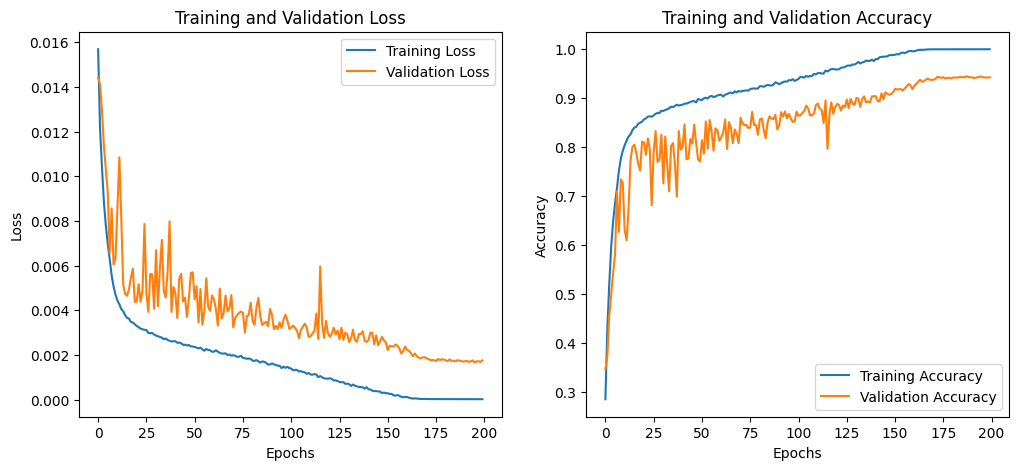

In [ ]:
# Initialize ResNet18 & Train
resnet = ResNet18(num_classes=NUM_CLASSES)

resnet = resnet.to(DEVICE)

summary(resnet, (3, 32, 32))

train_data = train_model(resnet, DEVICE, 'resnet18', learning_rate=0.1)

training_summary(*train_data)


## **Results**

In [ ]:
# Compare Models on testing dataset
def test(model, loader, device):
    model.eval()

    correct = 0
    total = 0 

    with torch.no_grad(): 
         for data in loader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(inputs)

            # Get predictions and update counts
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # Compute accuracy
    accuracy = 100 * correct / total
    return accuracy

print(f"VGG16 Test Accuracy: {test(vgg16, test_loader, DEVICE)}")
print(f'MobileNetV2 Test Accuracy: {test(mobilenet, test_loader, DEVICE)}')
print(f'ResNet18 Testing Accuracy: {test(resnet, test_loader, DEVICE)}')

VGG16 Test Accuracy: 92.97
MobileNetV2 Test Accuracy: 92.25
ResNet18 Testing Accuracy: 94.71


While further hyperparameter tuning may improve our testing accuracies, this is good enough for our purposes.  